# A5 1-D and 2-D Convolutional Neural Networks in Pytorch

* A5.4: *Changed structure of `CNN2D.__init__` by having it call `make_cnn_and_fc_layers` function. It is this function that `CNN1D` must override., not the `__init__` constructor.*
* A5.3: *Added two missing statements in `CNN2D` that initialize `layeri` to 0 and increment it by 1*
* A5.2: *added an exception to `CNN2D.__init__` code that provides a helpful message if you specify an impossible configuration for convolutional layers.  Repeat this exception code in your `CNN1D.__init__` function.*
* A5.1: *small edit in CNN2D to allow empty list for `n_hiddens_per_fc_layer`.*

In this assignment, you will experiment with the given convolutional neural network for 2-dimensional input samples (images), in class `CNN2D`, by applying it to the MNIST data.  You will also define a new class for handling 1-dimensional input samples, called `CNN1D`, that extends `CNN2D`.

In [2]:
import numpy as np
import torch
import pandas

import matplotlib.pyplot as plt

## `CNN2D` class

Here is a definition of `CNN2D`.

In [3]:
import numpy as np
import torch


class CNN2D(torch.nn.Module):

    def __init__(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):

        super().__init__()

        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers
            or len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')

        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu

        self.make_conv_and_fc_layers(n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                     patch_size_per_conv_layer, stride_per_conv_layer)
        
        self.Xmeans = None
        self.to(self.device)

    def make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                patch_size_per_conv_layer, stride_per_conv_layer):
                # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = 1
        input_hw = int(np.sqrt(n_inputs))  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv2d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1
           
        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw ** 2 * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

    def forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append(self.activation_function(conv_layer(Ys[-1])))

        flattened_input = Ys[-1].reshape(n_samples, -1)

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                Ys.append(self.activation_function(fc_layer(flattened_input)))
            else:
                Ys.append(self.activation_function(fc_layer(Ys[-1])))

        if len(self.fc_layers) == 1:
            # only the output layer
            Ys.append(self.fc_layers[-1](flattened_input))
        else:
            Ys.append(self.fc_layers[-1](Ys[-1]))

        return Ys

    def forward(self, X):
        Ys = self.forward_all_outputs(X)
        return Ys[-1]

    def train(self, X, T, batch_size, n_epochs, learning_rate, method='sgd', verbose=True):
        '''X and T must be numpy arrays'''

        self.classes = np.unique(T)
        T = np.arange(len(self.classes))[np.where(T.reshape(-1, 1) == self.classes)[1]]

        # Set data matrices to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        T = torch.from_numpy(T).long().to(self.device)  # required for classification in pytorch

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing
        #print(X.shape,self.Xmeans.shape)
        # Standardize X
        #print(X.shape,self.Xmeans.shape)
        X = (X - self.Xmeans) / self.Xstds

        X.requires_grad_(True)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        CELoss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.error_trace = []

        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0

            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                T_batch = T[start:end, ...]

                Y = self.forward(X_batch)

                loss = CELoss(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

            self.error_trace.append(loss_sum / num_batches)

            if verbose and (epoch + 1) % (max(1, n_epochs // 10)) == 0:
                print(f'{method}: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')
        #print(self.Xmeans.shape)
        return self

    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1, 1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y

    def use(self, X):
        # Set input matrix to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        # Standardize X
        #print(X.shape,self.Xmeans.shape)
        X = (X - self.Xmeans) / self.Xstds
        # Calculate output of net for all samples in X
        Y = self.forward(X)
        # Convert output to class probabilities
        probs = self.softmax(Y)
        # For each sample pick highest probability and translate that to class labels
        classes = self.classes[torch.argmax(probs, axis=1).cpu().numpy()].reshape(-1, 1)
        return classes, probs.detach().cpu().numpy()

### CNN2D on MNIST Digits

We will use a bunch (50,000) images of hand drawn digits from [this deeplearning.net site](http://deeplearning.net/tutorial/gettingstarted.html).  Download `mnist.pkl.gz`. 

This pickle file includes data already partitioned into training, validation, and test sets.  To read it into python, use the following steps

In [4]:
import pickle
import gzip

with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = (train_set[1]).reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

Xtrain = Xtrain.reshape(-1, 1, 28, 28)
Xtest = Xtest.reshape(-1, 1, 28, 28)
Xval = Xval.reshape(-1, 1, 28, 28)


print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 1, 28, 28) (50000, 1) (10000, 1, 28, 28) (10000, 1) (10000, 1, 28, 28) (10000, 1)


In [5]:
device = 'cpu'
if torch.cuda.is_available():
    y_or_n = input('Would you like to run on the GPU? (y or n): ')
    if y_or_n == 'y' or y_or_n == 'yes':
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on', device)

Running on cpu


In [6]:
len(np.unique(Ttrain))

10

In [ ]:
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [10, 5]
stride_per_conv_layer=[4, 2]
n_hiddens_per_fc_layer = [5]

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

plt.plot(cnnet.error_trace, label='Pytorch')
plt.title('MNIST')

In [ ]:
def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pandas.DataFrame(table, index=class_names, columns=class_names)
    return conf_matrix

In [ ]:
Classes, _ = cnnet.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest)

### Experiments

To explore the effects of different CNN structures, show results for the following steps.  For each use the same number of epochs, batch size, and learning rate as used above.

1. Compare test accuracy of CNN2D nets with one, two and three convolutional layers, each with 10 units and patch sizes of 5 and strides of 2.
2. Using the best number of convolutional layers found in Step 1, compare the test accuracies of CNN2d nets with zero, one, and two fully-connected layers each with 10 hidden units.

Combine the results of each of your runs and display them in a `pandas.Dataframe` that includes the network structure and percent correct on train and test sets. Discuss your results, and describe the network structure and training parameters that produced the best test results.

In [ ]:
Pr=len(np.unique(Ttrain))

In [ ]:
def run_experiment(n_hiddens_per_conv_layer,patch_size_per_conv_layer,stride_per_conv_layer,n_hiddens_per_fc_layer):
  results = []
  nh1=[]
  np34=[]
  ns=[]


  n_epochs = 20
  batch_size = 500
  learning_rate = 0.01
  for s1 in stride_per_conv_layer:
    if s1 not in ns:
      ns.append(s1)
      for p1 in patch_size_per_conv_layer:
        if p1 not in np34:
          np34.append(p1)
          for nh in n_hiddens_per_conv_layer:
            if nh not in nh1:
              nh1.append(nh)
              print(f'For {nh} no of hidden layer ,{p1} kernel size ,{s1} patch size')
              cnnet = CNN2D(28 * 28, nh, n_hiddens_per_fc_layer, Pr, p1, s1, device=device)

              cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
              Train_classes, Train_probs = cnnet.use(Xtrain)
              Test_classes, Test_probs = cnnet.use(Xtest)
              Validate_classes, Validate_probs = cnnet.use(Xval)
              Train_percent = np.mean(Train_classes == Ttrain) * 100
              Test_percent = np.mean(Test_classes == Ttest) * 100 
              Validate_percent = np.mean(Validate_classes == Tval) * 100 
              results.append([nh, p1,s1,Train_percent, Test_percent, Validate_percent])
              df = pandas.DataFrame(results, columns=('Hidden Conv Layers','Patch Size','stride size' ,'Train', 'Validate', 'Test'))
              break
          break
  return df



In [ ]:
df=run_experiment([[10],[10,10],[10,10,10]],[[5],[5,5],[5,5,5]],[[2],[2,2],[1,1,1]],[])

In [ ]:
print(df)

The best configuration :- 
Hidden Conv Layer - [10,10,10].
Patch Size - [5,5,5]
Stride Size- [1,1,1]
For this configuration the test accuracy is maximum i.e 97.65 %.
However here I have not connected any fully connected layer.


In [ ]:
plt.plot(cnnet.error_trace, label='Pytorch')
plt.title('MNIST') 

In [0]:
def best_config(n_hiddens_per_conv_layer,patch_size_per_conv_layer,stride_per_conv_layer,n_hiddens_per_fc_layer):
  n_epochs = 20
  batch_size = 500
  learning_rate = 0.01
  results1=[]
  for fc in n_hiddens_per_fc_layer: 
      cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, fc, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)


      cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
      Train_classes, Train_probs = cnnet.use(Xtrain)
      Test_classes, Test_probs = cnnet.use(Xtest)
      Validate_classes, Validate_probs = cnnet.use(Xval)
      Train_percent = np.mean(Train_classes == Ttrain) * 100
      Test_percent = np.mean(Test_classes == Ttest) * 100 
      Validate_percent = np.mean(Validate_classes == Tval) * 100 
      results1.append([n_hiddens_per_conv_layer, fc , Train_percent, Test_percent, Validate_percent])
      df1 = pandas.DataFrame(results1, columns=('Conv Layers', 'FC Layer', 'Train', 'Validate', 'Test'))
    
  return df1



Text(0.5, 1.0, 'MNIST')

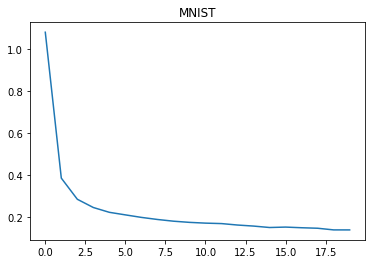

In [15]:
plt.plot(cnnet.error_trace, label='Pytorch')
plt.title('MNIST')

In [16]:
df1=best_config([10,10,10],[5,5,5],[1,1,1],[[],[10],[10,10]])

adam: Epoch 2 Loss 0.191
adam: Epoch 4 Loss 0.129
adam: Epoch 6 Loss 0.142
adam: Epoch 8 Loss 0.140
adam: Epoch 10 Loss 0.111
adam: Epoch 12 Loss 0.127
adam: Epoch 14 Loss 0.109
adam: Epoch 16 Loss 0.089
adam: Epoch 18 Loss 0.080
adam: Epoch 20 Loss 0.081
adam: Epoch 2 Loss 0.316
adam: Epoch 4 Loss 0.222
adam: Epoch 6 Loss 0.204
adam: Epoch 8 Loss 0.192
adam: Epoch 10 Loss 0.172
adam: Epoch 12 Loss 0.176
adam: Epoch 14 Loss 0.159
adam: Epoch 16 Loss 0.163
adam: Epoch 18 Loss 0.160
adam: Epoch 20 Loss 0.153
adam: Epoch 2 Loss 0.396
adam: Epoch 4 Loss 0.310
adam: Epoch 6 Loss 0.257
adam: Epoch 8 Loss 0.232
adam: Epoch 10 Loss 0.204
adam: Epoch 12 Loss 0.211
adam: Epoch 14 Loss 0.199
adam: Epoch 16 Loss 0.202
adam: Epoch 18 Loss 0.188
adam: Epoch 20 Loss 0.179


In [17]:
print (df1)

    Conv Layers  FC Layer   Train  Validate   Test
0  [10, 10, 10]        []  98.862     97.79  97.49
1  [10, 10, 10]      [10]  95.590     95.65  95.80
2  [10, 10, 10]  [10, 10]  94.964     95.47  95.36


Best Configuration:-

Convolution Layer- [10,10,10]
Patch size- [5,5,5]
Stride Size- [1,1,1]
Fully Connected Layer- [ ]

Adding fully connected layer to the best configuration from the above experiment. 
The best configuration is achieved when there is no fully connected layer. The test accuracy in this case is 97.49 %. When more fully connected layer is added there is a drop in the test accuracy.

## CNN1D

Complete the following code cell to define `CNN1D`.  The only change from `CNN2D` that is required is in the constructor.  Complete these steps.

1. Copy the `__init__` function from `CNN2D`.
2. For each convolutional layer, create a `torch.nn.Conv1d` object instead of a `torch.nn.Conv2d` object.
3. Modify the statement `input_hw = int(np.sqrt(n_inputs))` appropriately.
4. Modify the statement `n_in = input_hw ** 2 * n_in` appropriately.

In [0]:
class CNN1D(CNN2D):

    def make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                patch_size_per_conv_layer, stride_per_conv_layer):
                        # Create all convolutional layers
        n_in = 1
        input_hw = n_inputs  
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv1d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            if conv_layer_output_hw < 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1
           
        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw ** 1 * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

### Toy Data to Test `CNN1D`

Here is some toy data to test your `CNN1D` definition.  Each sample is now 1-dimensional.  Let's make vectors of two kinds, ones with square pulses and ones with triangular pulses, at random locations and random durations. Both kinds will be 100 values, with zeros between the waves long.

In [0]:
def make_square_pulse():
    sample = np.zeros(100)
    for i in range(np.random.randint(1, 5)):  # making from 1 to 4 pulses
        start = np.random.randint(0, 80)
        width = np.random.randint(5, 20)
        sample[start:start + width] = 1
    return sample

In [20]:
make_square_pulse()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

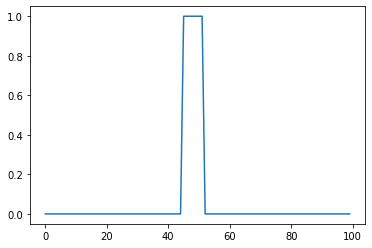

In [21]:
plt.plot(make_square_pulse());

In [0]:
def make_triangular_pulse():
    sample = np.zeros(100)
    for i in range(np.random.randint(1, 5)):  # making from 1 to 4 pulses
        start = np.random.randint(0, 80)
        width = np.random.randint(5, 20)
        if width % 2 == 1:
            width += 1  # if odd, make it even
        sample[start:start + width // 2] = np.linspace(0, 1, width // 2)
        sample[start + width // 2:start + width] = np.linspace(1, 0, width // 2)
    return sample

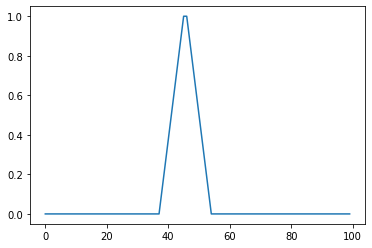

In [23]:
plt.plot(make_triangular_pulse());

In [24]:
n_each = 500
Xtrain = np.array([make_square_pulse() for i in range(n_each)] +
                   [make_triangular_pulse() for i in range(n_each)])
Ttrain = np.array(['square'] * n_each + ['triangular'] * n_each).reshape(-1, 1)
n_each = 500
Xtest = np.array([make_square_pulse() for i in range(n_each)] +
                   [make_triangular_pulse() for i in range(n_each)])
Ttest = np.array(['square'] * n_each + ['triangular'] * n_each).reshape(-1, 1)
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1000, 100), (1000, 1), (1000, 100), (1000, 1))

In [25]:
np.newaxis == None

True

In [26]:
Xtrain = Xtrain[:, None, :]
Xtrain.shape

(1000, 1, 100)

In [27]:
Xtrain = Xtrain.reshape(Xtrain.shape[0], 1, -1)
Xtest = Xtest.reshape(Xtest.shape[0], 1, -1)
Xtrain.shape, Xtest.shape

((1000, 1, 100), (1000, 1, 100))

adam: Epoch 10 Loss 0.614
adam: Epoch 20 Loss 0.395
adam: Epoch 30 Loss 0.141
adam: Epoch 40 Loss 0.029
adam: Epoch 50 Loss 0.006
adam: Epoch 60 Loss 0.002
adam: Epoch 70 Loss 0.001
adam: Epoch 80 Loss 0.000
adam: Epoch 90 Loss 0.000
adam: Epoch 100 Loss 0.000


Text(0.5, 1.0, 'Pulses')

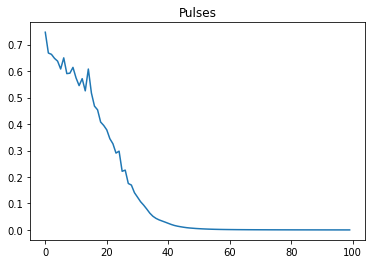

In [28]:
cnnet1 = CNN1D(100, [10, 5], [5, 5], 2, [10, 4], [1, 2], device=device)

n_epochs = 100
batch_size = 10
learning_rate = 0.001

cnnet1.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

plt.plot(cnnet1.error_trace, label='Pytorch')
plt.title('Pulses')

In [29]:
Classes, _ = cnnet1.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest)

Test accuracy in percent correct: 98.40


,square,triangular
square,97.0,3.0
triangular,0.2,99.8


torch.Size([10, 10])

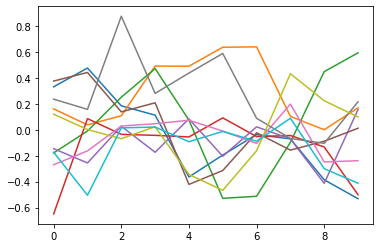

In [30]:
W = list(cnnet1.children())[0][0].weight.data.cpu()  # in case running on GPU
plt.plot(W[:, 0, :].T);
W[:, 0, :].T.shape

### Experiments on ECG Data

An [electrocardiogram](), or ECG, is a record in time of a voltage generated by the heart.  It can be used to diagnose abnormalities in the heart.

Public datasets containing ECG traces are available, such as the [Non-Invasive Fetal ECG Arrhythmia Database](https://physionet.org/content/nifeadb/1.0.0/) site. The data files there are in a standard waveform-database (WFDB) format.  As is often the case for most standard data formats you run in to, a python package exists for reading this data, called [wfdb](https://github.com/MIT-LCP/wfdb-python) that you can install using [conda](https://anaconda.org/conda-forge/wfdb).

This data set includes ECG from normal patients and from ones with arrythmias, with data file names like `ARR_01.dat` and `NR_01.dat`, respectively.  We have already downloaded these files, read them in using the `wfdb` package and collected them into segments of 2000 voltages.  The sample rate for this data is 1000 Hz, so 2000 voltages spans 2 seconds. Download this data set from [ecg.npy](https://www.cs.colostate.edu/~anderson/cs445/notebooks/ecg.npy) 

Now, our job for our `CNN1D` is to classify each 2000 sample segment into the classes `normal` or `arrythmia`.

After you have downloaded `ecg.npy`, you can load it and plot a few samples.

In [31]:
ecg = np.load('ecg.npy')
arr = ecg['arrythmia']
norm = ecg['normal']
arr.shape, norm.shape

((2429, 2000), (3634, 2000))

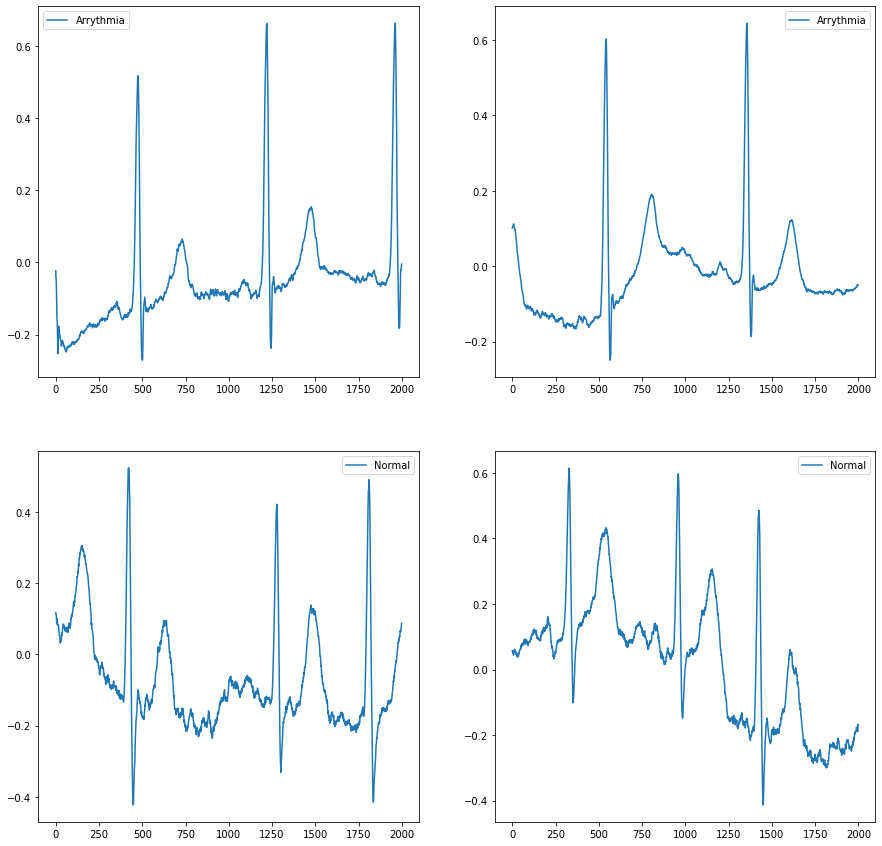

In [32]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.plot(arr[0])
plt.legend(('Arrythmia',))
plt.subplot(2, 2, 2)
plt.plot(arr[100])
plt.legend(('Arrythmia',))

plt.subplot(2, 2, 3)
plt.plot(norm[0])
plt.legend(('Normal',))
plt.subplot(2, 2, 4)
plt.plot(norm[100])
plt.legend(('Normal',));

Now, let's stack the `arr` and `norm` samples together, create class labels for each sample, randomly rearrange them, and divide into train and test sets.

In [33]:
X = np.vstack((arr, norm))
X = X.reshape(X.shape[0], 1, -1)
T = np.hstack((['arr'] * arr.shape[0], ['nr'] * norm.shape[0])).reshape(-1, 1)
n_samples = X.shape[0]
rows = np.arange(n_samples)
np.random.shuffle(rows)
n_train = int(n_samples * 0.8)
Xtrain = X[rows[:n_train], ...]
Ttrain = T[rows[:n_train], ...]

Xtest = X[rows[n_train:], ...]
Ttest = T[rows[n_train:], ...]

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((4850, 1, 2000), (4850, 1), (1213, 1, 2000), (1213, 1))

In [34]:
Ttrain

array([['arr'],
       ['arr'],
       ['arr'],
       ...,
       ['arr'],
       ['nr'],
       ['nr']], dtype='<U3')

Okay, ready to train.  Create a `CNN1D` network with a statements like this.

In [35]:
cnn1d = CNN1D(Xtrain.shape[-1], [5, 10], [10, 10], 2, [100, 20], [20, 5], device=device)
cnn1d.train(Xtrain, Ttrain, batch_size, 10, learning_rate, method='adam')

adam: Epoch 1 Loss 0.668
adam: Epoch 2 Loss 0.596
adam: Epoch 3 Loss 0.556
adam: Epoch 4 Loss 0.525
adam: Epoch 5 Loss 0.487
adam: Epoch 6 Loss 0.445
adam: Epoch 7 Loss 0.409
adam: Epoch 8 Loss 0.362
adam: Epoch 9 Loss 0.333
adam: Epoch 10 Loss 0.296


CNN1D(
  (conv_layers): ModuleList(
    (0): Conv1d(1, 5, kernel_size=(100,), stride=(20,))
    (1): Conv1d(5, 10, kernel_size=(20,), stride=(5,))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=160, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [0]:
def run_experiment_ecg(n_hiddens_per_conv_layer,patch_size_per_conv_layer,stride_per_conv_layer,n_hiddens_per_fc_layer,act='tanh'):
  n_inputs=Xtrain.shape[-1]
  n_outputs=2
  ns=[]
  np34=[]
  nh1=[]
  results=[]
  o89=[]
  for s1 in stride_per_conv_layer:
      if s1 not in ns:
        ns.append(s1)
        for p1 in patch_size_per_conv_layer:
          if p1 not in np34:
            np34.append(p1)
            for nh in n_hiddens_per_conv_layer:
              if nh not in nh1:
                nh1.append(nh)
                for oi in n_hiddens_per_fc_layer:
                  if True:
                    o89.append(oi)
                    print(f'For {nh} no of hidden layer ,{p1} kernel size ,{s1} patch size,{oi} fnc')
                    cnn1d = CNN1D(n_inputs, nh, oi, n_outputs, p1, s1,act, device=device)
                    cnn1d.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
                    #print(Xtrain.shape,cnnet.Xmeans)
                    Train_classes, Train_probs = cnn1d.use(Xtrain)
                    Test_classes, Test_probs = cnn1d.use(Xtest)
                    #Validate_classes, Validate_probs = cnn1d.use(Xval)
                    Train_percent = np.mean(Train_classes == Ttrain) * 100
                    Test_percent = np.mean(Test_classes == Ttest) * 100 
                    #Validate_percent = np.mean(Validate_classes == Tval) * 100 
                    results.append([nh,p1,s1,oi, Train_percent, Test_percent])
                    
                break
            break
  df = pandas.DataFrame(results, columns=('Hidden Layers','Patch Size', 'Stride Size','FC Layer', 'Train',  'Test'))
                
  return df


#cnn1d = CNN1D(n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs, patch_size_per_conv_layer, stride_per_conv_layer, device=device)
#cnn1d.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

In [37]:
df=run_experiment_ecg([[5],[10,5],[10,10,5]],[[5],[10,5],[20,10,5]],[[3],[5,2],[10,5,1]],[[],[10],[10,5],[10,10,5]])

For [5] no of hidden layer ,[5] kernel size ,[3] patch size,[] fnc
adam: Epoch 10 Loss 0.651
adam: Epoch 20 Loss 0.634
adam: Epoch 30 Loss 0.622
adam: Epoch 40 Loss 0.610
adam: Epoch 50 Loss 0.597
adam: Epoch 60 Loss 0.585
adam: Epoch 70 Loss 0.575
adam: Epoch 80 Loss 0.567
adam: Epoch 90 Loss 0.560
adam: Epoch 100 Loss 0.554
For [5] no of hidden layer ,[5] kernel size ,[3] patch size,[10] fnc
adam: Epoch 10 Loss 0.551
adam: Epoch 20 Loss 0.481
adam: Epoch 30 Loss 0.438
adam: Epoch 40 Loss 0.401
adam: Epoch 50 Loss 0.382
adam: Epoch 60 Loss 0.357
adam: Epoch 70 Loss 0.336
adam: Epoch 80 Loss 0.311
adam: Epoch 90 Loss 0.306
adam: Epoch 100 Loss 0.292
For [5] no of hidden layer ,[5] kernel size ,[3] patch size,[10, 5] fnc
adam: Epoch 10 Loss 0.541
adam: Epoch 20 Loss 0.465
adam: Epoch 30 Loss 0.421
adam: Epoch 40 Loss 0.385
adam: Epoch 50 Loss 0.360
adam: Epoch 60 Loss 0.343
adam: Epoch 70 Loss 0.322
adam: Epoch 80 Loss 0.314
adam: Epoch 90 Loss 0.322
adam: Epoch 100 Loss 0.296
For [5] n

In [0]:
#df=run_experiment_ecg([[10]],[[5]],[[2]],[[50,50,10]])

In [39]:
df

,Hidden Layers,Patch Size,Stride Size,FC Layer,Train,Test
0,[5],[5],[3],[],66.865979,54.740313
1,[5],[5],[3],[10],86.597938,67.600989
2,[5],[5],[3],"[10, 5]",85.731959,66.034625
3,[5],[5],[3],"[10, 10, 5]",60.659794,57.048640
4,"[10, 5]","[10, 5]","[5, 2]",[],70.247423,61.582852
5,"[10, 5]","[10, 5]","[5, 2]",[10],97.113402,65.127782
6,"[10, 5]","[10, 5]","[5, 2]","[10, 5]",88.948454,64.303380
7,"[10, 5]","[10, 5]","[5, 2]","[10, 10, 5]",94.515464,64.550701
8,"[10, 10, 5]","[20, 10, 5]","[10, 5, 1]",[],98.144330,92.827700
9,"[10, 10, 5]","[20, 10, 5]","[10, 5, 1]",[10],96.082474,85.985161


Best configuration :
hidden layer - [10,10,5]
Patch size - [20,10,5]
Stride size - [10,5,1]
Fully Connected Layer - [ ]

The test accuracy is this configuration is 92.82%.
Adding more fully connected layer makes the model overfit the data as the testing accuracy decreases with more fully connected layer.
When a smaller convolution layer is used the model was not able to train properly. Both Training and Testing accuracy was smaller in this case. 

In [0]:
#df=run_experiment_ecg([[10,10]],[[5,5]],[[3,3]],[[10,5]],'relu')

Now, experiment with at least ten different network structures, patch sizes and strides and compare them with the percent accuracy on test data.  Combine the results of each of your runs and display them in a `pandas.Dataframe` that includes the network structure and percent correct on train and test sets. Discuss your results, and describe the network structure and training parameters that produced the best test results.

## Grading and Check-In
Download [A5grader.zip](https://www.cs.colostate.edu/~anderson/cs445/notebooks/A5grader.zip) and extract A5grader.py from it. Run the code in the following cell to demonstrate an example grading session. Remember to test your code with additional tests of your own design. Your notebook must be named as Lastname-A5.ipynb.  

When ready, submit your notebook via the A5 link in our class Canvas web page.

In [42]:
%run -i A5grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Chakraborty-A5_4.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing

    xs = np.arange(100)
    n_each = 500
    n_samples = n_each * 2
    X = np.array([np.sin(xs / 2) + np.random.normal(0, 1, size=100) for i in range(n_each)] +
                 [np.sin(xs / 3) + np.random.normal(0, 1, size=100) for i in range(n_each)])
    X = X[:, np.newaxis, :]
    T = np.array([2] * n_each + [3] * n_each).reshape(-1, 1)
    rows = np.arange(n_samples)
    np.random.shuffle(rows)
    X = X[rows, ...]
    T = T[rows, ...]
    n_train = int(n_samples * 0.8)
    Xtrain = X[:n_train, ...]
    Ttrain = T[:n_train, :]
    Xtest = X[n_train:, ...]
    Ttest = T[n_train:, :]

    cnn1d = CNN1D(100, [5, 5], [3], 2, [10, 5], [1, 2])
    cnn1d.train(Xtrain, Ttrain, 10, 20, 0.01, method='adam')

    perc_train = 100 * np.mean

<Figure size 432x288 with 0 Axes>

## Extra Credit
Earn up to 3 extra credit points on this assignment by doing any or all of the following experiments. 

1. Compare your results on the MNIST data by using `relu` versus `tanh` activation functions. Show and discuss the results.
2. Compare your results on the MNIST data using `adam` versus `sgd`. Show and discuss the results.
3. Download another image data set, apply your `CNN2D` class to this data and discuss the results.

In [15]:
import pickle
import gzip

with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = (train_set[1]).reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

Xtrain = Xtrain.reshape(-1, 1, 28, 28)
Xtest = Xtest.reshape(-1, 1, 28, 28)
Xval = Xval.reshape(-1, 1, 28, 28)


print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 1, 28, 28) (50000, 1) (10000, 1, 28, 28) (10000, 1) (10000, 1, 28, 28) (10000, 1)


In [0]:
def run_experiment(n_hiddens_per_conv_layer,patch_size_per_conv_layer,stride_per_conv_layer,n_hiddens_per_fc_layer,act='tanh'):
  results = []
  nh1=[]
  np34=[]
  ns=[]


  n_epochs = 20
  batch_size = 500
  learning_rate = 0.01
  for s1 in stride_per_conv_layer:
    if s1 not in ns:
      ns.append(s1)
      for p1 in patch_size_per_conv_layer:
        if p1 not in np34:
          np34.append(p1)
          for nh in n_hiddens_per_conv_layer:
            if nh not in nh1:
              nh1.append(nh)
              print(f'For {nh} no of hidden layer ,{p1} kernel size ,{s1} patch size')
              cnnet = CNN2D(28 * 28, nh, n_hiddens_per_fc_layer, Pr, p1, s1, device=device)

              cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
              Train_classes, Train_probs = cnnet.use(Xtrain)
              Test_classes, Test_probs = cnnet.use(Xtest)
              Validate_classes, Validate_probs = cnnet.use(Xval)
              Train_percent = np.mean(Train_classes == Ttrain) * 100
              Test_percent = np.mean(Test_classes == Ttest) * 100 
              Validate_percent = np.mean(Validate_classes == Tval) * 100 
              results.append([nh,p1,s1, Train_percent, Test_percent, Validate_percent])
              df = pandas.DataFrame(results, columns=('Hidden Layers','Patch Size ','Stride Size', 'Train', 'Validate', 'Test'))
              break
          break
  return df



In [20]:
df=run_experiment([[10],[10,10],[10,10,10]],[[5],[5,5],[5,5,5]],[[2],[2,2],[1,1,1]],[],'tanh')
print("FOR tanh ACTIVATION")
print (df)

For [10] no of hidden layer ,[5] kernel size ,[2] patch size
adam: Epoch 2 Loss 0.237
adam: Epoch 4 Loss 0.141
adam: Epoch 6 Loss 0.098
adam: Epoch 8 Loss 0.078
adam: Epoch 10 Loss 0.065
adam: Epoch 12 Loss 0.058
adam: Epoch 14 Loss 0.053
adam: Epoch 16 Loss 0.058
adam: Epoch 18 Loss 0.055
adam: Epoch 20 Loss 0.042
For [10, 10] no of hidden layer ,[5, 5] kernel size ,[2, 2] patch size
adam: Epoch 2 Loss 0.191
adam: Epoch 4 Loss 0.119
adam: Epoch 6 Loss 0.094
adam: Epoch 8 Loss 0.079
adam: Epoch 10 Loss 0.074
adam: Epoch 12 Loss 0.067
adam: Epoch 14 Loss 0.063
adam: Epoch 16 Loss 0.061
adam: Epoch 18 Loss 0.056
adam: Epoch 20 Loss 0.054
For [10, 10, 10] no of hidden layer ,[5, 5, 5] kernel size ,[1, 1, 1] patch size
adam: Epoch 2 Loss 0.164
adam: Epoch 4 Loss 0.160
adam: Epoch 6 Loss 0.142
adam: Epoch 8 Loss 0.169
adam: Epoch 10 Loss 0.102
adam: Epoch 12 Loss 0.100
adam: Epoch 14 Loss 0.120
adam: Epoch 16 Loss 0.095
adam: Epoch 18 Loss 0.085
adam: Epoch 20 Loss 0.098
FOR tanh ACTIVATION

In [0]:
def best_config(n_hiddens_per_conv_layer,patch_size_per_conv_layer,stride_per_conv_layer,n_hiddens_per_fc_layer,act='tanh'):
  n_epochs = 20
  batch_size = 500
  learning_rate = 0.01
  results1=[]
  for fc in n_hiddens_per_fc_layer: 
      cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, fc, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)


      cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
      Train_classes, Train_probs = cnnet.use(Xtrain)
      Test_classes, Test_probs = cnnet.use(Xtest)
      Validate_classes, Validate_probs = cnnet.use(Xval)
      Train_percent = np.mean(Train_classes == Ttrain) * 100
      Test_percent = np.mean(Test_classes == Ttest) * 100 
      Validate_percent = np.mean(Validate_classes == Tval) * 100 
      results1.append([n_hiddens_per_conv_layer, fc , Train_percent, Test_percent, Validate_percent])
      df1 = pandas.DataFrame(results1, columns=('Conv Layers', 'FC Layer', 'Train', 'Validate', 'Test'))
    
  return df1



In [22]:
print("For Best Configuration for Tanh")
df1=best_config([10,10,10],[5,5,5],[1,1,1],[[],[10],[10,10]])
print(df1)


For Best Configuration for Tanh
adam: Epoch 2 Loss 0.187
adam: Epoch 4 Loss 0.152
adam: Epoch 6 Loss 0.180
adam: Epoch 8 Loss 0.187
adam: Epoch 10 Loss 0.128
adam: Epoch 12 Loss 0.101
adam: Epoch 14 Loss 0.090
adam: Epoch 16 Loss 0.088
adam: Epoch 18 Loss 0.092
adam: Epoch 20 Loss 0.088
adam: Epoch 2 Loss 0.321
adam: Epoch 4 Loss 0.242
adam: Epoch 6 Loss 0.211
adam: Epoch 8 Loss 0.186
adam: Epoch 10 Loss 0.194
adam: Epoch 12 Loss 0.174
adam: Epoch 14 Loss 0.167
adam: Epoch 16 Loss 0.174
adam: Epoch 18 Loss 0.174
adam: Epoch 20 Loss 0.189
adam: Epoch 2 Loss 0.389
adam: Epoch 4 Loss 0.287
adam: Epoch 6 Loss 0.262
adam: Epoch 8 Loss 0.236
adam: Epoch 10 Loss 0.242
adam: Epoch 12 Loss 0.227
adam: Epoch 14 Loss 0.228
adam: Epoch 16 Loss 0.194
adam: Epoch 18 Loss 0.190
adam: Epoch 20 Loss 0.198
    Conv Layers  FC Layer   Train  Validate   Test
0  [10, 10, 10]        []  99.022     97.74  97.81
1  [10, 10, 10]      [10]  95.020     95.63  95.25
2  [10, 10, 10]  [10, 10]  93.148     93.21  93

In [23]:
df=run_experiment([[10],[10,10],[10,10,10]],[[5],[5,5],[5,5,5]],[[2],[2,2],[1,1,1]],[],'relu')
print("FOR relu ACTIVATION")
print (df)

For [10] no of hidden layer ,[5] kernel size ,[2] patch size
adam: Epoch 2 Loss 0.234
adam: Epoch 4 Loss 0.131
adam: Epoch 6 Loss 0.094
adam: Epoch 8 Loss 0.073
adam: Epoch 10 Loss 0.061
adam: Epoch 12 Loss 0.056
adam: Epoch 14 Loss 0.048
adam: Epoch 16 Loss 0.044
adam: Epoch 18 Loss 0.047
adam: Epoch 20 Loss 0.054
For [10, 10] no of hidden layer ,[5, 5] kernel size ,[2, 2] patch size
adam: Epoch 2 Loss 0.193
adam: Epoch 4 Loss 0.117
adam: Epoch 6 Loss 0.093
adam: Epoch 8 Loss 0.077
adam: Epoch 10 Loss 0.069
adam: Epoch 12 Loss 0.063
adam: Epoch 14 Loss 0.060
adam: Epoch 16 Loss 0.059
adam: Epoch 18 Loss 0.062
adam: Epoch 20 Loss 0.057
For [10, 10, 10] no of hidden layer ,[5, 5, 5] kernel size ,[1, 1, 1] patch size
adam: Epoch 2 Loss 0.203
adam: Epoch 4 Loss 0.163
adam: Epoch 6 Loss 0.153
adam: Epoch 8 Loss 0.133
adam: Epoch 10 Loss 0.101
adam: Epoch 12 Loss 0.089
adam: Epoch 14 Loss 0.101
adam: Epoch 16 Loss 0.073
adam: Epoch 18 Loss 0.102
adam: Epoch 20 Loss 0.080
FOR relu ACTIVATION

In [24]:
print("For Best Configuration for Relu")
df1=best_config([10,10,10],[5,5,5],[1,1,1],[[],[10],[10,10]])
print(df1)


For Best Configuration for Relu
adam: Epoch 2 Loss 0.176
adam: Epoch 4 Loss 0.163
adam: Epoch 6 Loss 0.158
adam: Epoch 8 Loss 0.140
adam: Epoch 10 Loss 0.099
adam: Epoch 12 Loss 0.127
adam: Epoch 14 Loss 0.091
adam: Epoch 16 Loss 0.102
adam: Epoch 18 Loss 0.092
adam: Epoch 20 Loss 0.077
adam: Epoch 2 Loss 0.361
adam: Epoch 4 Loss 0.244
adam: Epoch 6 Loss 0.229
adam: Epoch 8 Loss 0.208
adam: Epoch 10 Loss 0.184
adam: Epoch 12 Loss 0.201
adam: Epoch 14 Loss 0.175
adam: Epoch 16 Loss 0.162
adam: Epoch 18 Loss 0.161
adam: Epoch 20 Loss 0.165
adam: Epoch 2 Loss 0.399
adam: Epoch 4 Loss 0.288
adam: Epoch 6 Loss 0.265
adam: Epoch 8 Loss 0.239
adam: Epoch 10 Loss 0.236
adam: Epoch 12 Loss 0.212
adam: Epoch 14 Loss 0.210
adam: Epoch 16 Loss 0.208
adam: Epoch 18 Loss 0.190
adam: Epoch 20 Loss 0.197
    Conv Layers  FC Layer   Train  Validate   Test
0  [10, 10, 10]        []  99.250     98.05  97.99
1  [10, 10, 10]      [10]  94.644     94.80  94.96
2  [10, 10, 10]  [10, 10]  93.880     94.14  94

For both the activation function, the best configuration remains same.However, the testing accuracy in the case of relu activation is higher than that of tanh. 

Best configuration-

Conv Layer-[10,10,10]
Patch Size- [5,5,5]
Stride Size - [1,1,1]
FC Layer- [ ]

Testing accuracy of tanh= 97.81

Testing accuracy of relu= 97.99

In [25]:
print("For ADAM OPTIMIZER: ")
def run_experiment(n_hiddens_per_conv_layer,patch_size_per_conv_layer,stride_per_conv_layer,n_hiddens_per_fc_layer,act='tanh'):
  results = []
  nh1=[]
  np34=[]
  ns=[]


  n_epochs = 20
  batch_size = 500
  learning_rate = 0.01
  for s1 in stride_per_conv_layer:
    if s1 not in ns:
      ns.append(s1)
      for p1 in patch_size_per_conv_layer:
        if p1 not in np34:
          np34.append(p1)
          for nh in n_hiddens_per_conv_layer:
            if nh not in nh1:
              nh1.append(nh)
              print(f'For {nh} no of hidden layer ,{p1} kernel size ,{s1} patch size')
              cnnet = CNN2D(28 * 28, nh, n_hiddens_per_fc_layer, Pr, p1, s1, device=device)

              cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
              Train_classes, Train_probs = cnnet.use(Xtrain)
              Test_classes, Test_probs = cnnet.use(Xtest)
              Validate_classes, Validate_probs = cnnet.use(Xval)
              Train_percent = np.mean(Train_classes == Ttrain) * 100
              Test_percent = np.mean(Test_classes == Ttest) * 100 
              Validate_percent = np.mean(Validate_classes == Tval) * 100 
              results.append([nh, p1,s1,Train_percent, Test_percent, Validate_percent])
              df = pandas.DataFrame(results, columns=('Hidden Layers','Patch Size','Stride Size' ,'Train', 'Validate', 'Test'))
              break
          break
  return df



For ADAM OPTIMIZER: 


In [26]:
df=run_experiment([[10],[10,10],[10,10,10]],[[5],[5,5],[5,5,5]],[[2],[2,2],[1,1,1]],[],'tanh')
print("FOR ADAM: ")
print (df)

For [10] no of hidden layer ,[5] kernel size ,[2] patch size
adam: Epoch 2 Loss 0.235
adam: Epoch 4 Loss 0.134
adam: Epoch 6 Loss 0.092
adam: Epoch 8 Loss 0.067
adam: Epoch 10 Loss 0.058
adam: Epoch 12 Loss 0.056
adam: Epoch 14 Loss 0.058
adam: Epoch 16 Loss 0.049
adam: Epoch 18 Loss 0.048
adam: Epoch 20 Loss 0.036
For [10, 10] no of hidden layer ,[5, 5] kernel size ,[2, 2] patch size
adam: Epoch 2 Loss 0.187
adam: Epoch 4 Loss 0.119
adam: Epoch 6 Loss 0.098
adam: Epoch 8 Loss 0.082
adam: Epoch 10 Loss 0.073
adam: Epoch 12 Loss 0.068
adam: Epoch 14 Loss 0.063
adam: Epoch 16 Loss 0.061
adam: Epoch 18 Loss 0.058
adam: Epoch 20 Loss 0.060
For [10, 10, 10] no of hidden layer ,[5, 5, 5] kernel size ,[1, 1, 1] patch size
adam: Epoch 2 Loss 0.159
adam: Epoch 4 Loss 0.124
adam: Epoch 6 Loss 0.311
adam: Epoch 8 Loss 0.151
adam: Epoch 10 Loss 0.104
adam: Epoch 12 Loss 0.081
adam: Epoch 14 Loss 0.082
adam: Epoch 16 Loss 0.064
adam: Epoch 18 Loss 0.074
adam: Epoch 20 Loss 0.068
FOR ADAM: 
  Hidden

In [27]:
print("For SGD OPTIMIZER: ")
def run_experiment(n_hiddens_per_conv_layer,patch_size_per_conv_layer,stride_per_conv_layer,n_hiddens_per_fc_layer,act='tanh'):
  results = []
  nh1=[]
  np34=[]
  ns=[]


  n_epochs = 20
  batch_size = 500
  learning_rate = 0.01
  for s1 in stride_per_conv_layer:
    if s1 not in ns:
      ns.append(s1)
      for p1 in patch_size_per_conv_layer:
        if p1 not in np34:
          np34.append(p1)
          for nh in n_hiddens_per_conv_layer:
            if nh not in nh1:
              nh1.append(nh)
              print(f'For {nh} no of hidden layer ,{p1} kernel size ,{s1} patch size')
              cnnet = CNN2D(28 * 28, nh, n_hiddens_per_fc_layer, Pr, p1, s1, device=device)

              cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='sgd')
              Train_classes, Train_probs = cnnet.use(Xtrain)
              Test_classes, Test_probs = cnnet.use(Xtest)
              Validate_classes, Validate_probs = cnnet.use(Xval)
              Train_percent = np.mean(Train_classes == Ttrain) * 100
              Test_percent = np.mean(Test_classes == Ttest) * 100 
              Validate_percent = np.mean(Validate_classes == Tval) * 100 
              results.append([nh, p1,s1,Train_percent, Test_percent, Validate_percent])
              df = pandas.DataFrame(results, columns=('Hidden Layers', 'Patch Size','Stride Size','Train', 'Validate', 'Test'))
              break
          break
  return df



For SGD OPTIMIZER: 


In [28]:
df=run_experiment([[10],[10,10],[10,10,10]],[[5],[5,5],[5,5,5]],[[2],[2,2],[1,1,1]],[],'tanh')
print("FOR SGD: ")
print (df)

For [10] no of hidden layer ,[5] kernel size ,[2] patch size
sgd: Epoch 2 Loss 0.318
sgd: Epoch 4 Loss 0.268
sgd: Epoch 6 Loss 0.238
sgd: Epoch 8 Loss 0.214
sgd: Epoch 10 Loss 0.194
sgd: Epoch 12 Loss 0.176
sgd: Epoch 14 Loss 0.161
sgd: Epoch 16 Loss 0.148
sgd: Epoch 18 Loss 0.137
sgd: Epoch 20 Loss 0.127
For [10, 10] no of hidden layer ,[5, 5] kernel size ,[2, 2] patch size
sgd: Epoch 2 Loss 0.412
sgd: Epoch 4 Loss 0.318
sgd: Epoch 6 Loss 0.274
sgd: Epoch 8 Loss 0.244
sgd: Epoch 10 Loss 0.222
sgd: Epoch 12 Loss 0.203
sgd: Epoch 14 Loss 0.188
sgd: Epoch 16 Loss 0.174
sgd: Epoch 18 Loss 0.163
sgd: Epoch 20 Loss 0.152
For [10, 10, 10] no of hidden layer ,[5, 5, 5] kernel size ,[1, 1, 1] patch size
sgd: Epoch 2 Loss 0.231
sgd: Epoch 4 Loss 0.129
sgd: Epoch 6 Loss 0.092
sgd: Epoch 8 Loss 0.074
sgd: Epoch 10 Loss 0.063
sgd: Epoch 12 Loss 0.056
sgd: Epoch 14 Loss 0.050
sgd: Epoch 16 Loss 0.045
sgd: Epoch 18 Loss 0.041
sgd: Epoch 20 Loss 0.038
FOR SGD: 
  Hidden Layers Patch Size Stride Size 

The best configuration is same for both ADAM and SGD optimizer.
However the testing accuracy in the case of SGD is higher than in the case of ADAM.

Best Testing Accuracy of SGD : 98.42

Best Testing Accuracy of ADAM :98.06 